In [1]:
import cartopy
import pygsheets
import matplotlib
import matplotlib.pyplot as mp
import seaborn
import pandas
import shapely
import geopandas
import numpy

In [2]:
# ignore deprecation warning for multi-part geometries (plots still work for shapely<2.0)
import warnings
import shapely.errors#ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=shapely.errors.ShapelyDeprecationWarning)

In [3]:
sel_cmap = matplotlib.cm.get_cmap('Reds')
tracker_operating = sel_cmap(0.999)
tracker_construction = sel_cmap(0.8)
tracker_proposed = sel_cmap(0.6)
tracker_shelved = sel_cmap(0.4)
tracker_cancelled = sel_cmap(0.2)

## import pipeline data

In [4]:
#fuel_type = 'Gas'
fuel_type = 'Oil'
#fuel_type = 'Oil-and-Gas'

credentials_directory = '/Users/baird/Dropbox/_google-api/'
gc = pygsheets.authorize(client_secret=credentials_directory+'client_secret.json')

#spreadsheet = gc.open_by_key('1foPLE6K-uqFlaYgLPAUxzeXfDO5wOOqE7tibNHeqTek')
spreadsheet = gc.open_by_key('1YeYmh43_DvVI4DWpEvVPt3IUr3XzP4h4-X1FSf0Kew8') # specific doc for briefing

gas_pipes = spreadsheet.worksheet('title', 'Gas pipelines').get_as_df(start='A2')
oil_pipes = spreadsheet.worksheet('title', 'Oil/NGL pipelines').get_as_df(start='A2')

pipes_dict_df = spreadsheet.worksheet('title', 'Data dictionary').get_as_df()

if fuel_type == 'Gas':
    pipes_df_orig = gas_pipes.copy() #pandas.concat([oil_pipes, gas_pipes], ignore_index=True)
if fuel_type == 'Oil':
    pipes_df_orig = oil_pipes.copy()
if fuel_type == 'Oil-and-Gas':
    pipes_df_orig = pandas.concat([oil_pipes, gas_pipes], ignore_index=True)

In [5]:
# clean up rows that should not be distributed
# replace -- entries with NaN
#pipes_df_orig = pipes_df_orig.replace('--', numpy.nan)
pipes_df_orig = pipes_df_orig[pipes_df_orig['Status']!='N/A']
pipes_df_orig = pipes_df_orig[pipes_df_orig['Wiki']!='']

In [6]:
status_in_dev = ['Proposed', 
                 'Construction', 
                 'Shelved', 'Operating', 
                 'Mothballed', 
                 'Cancelled', 
                 'Retired', 
                 'Idle']
no_route_options = [
    'Unavailable', 
    'Capacity expansion only', 
    'Bidirectionality upgrade only',
    'Short route (< 100 km)', 
    'N/A',
    ''
]

# filter for the statuses above in the status_in_dev list (modify as desired)
#gas_pipes = gas_pipes[gas_pipes['Status'].str.lower().isin(status_in_dev)]

In [7]:
def convert_gfit_to_linestring(coord_str, pipeline_name):
    '''
    Takes string from GFIT column of coordinates for a single pipeline,
    converts that string into Shapely LineString or MultiLinestring.
    '''
    
    #print(pipeline_name)
    #print(coord_str, pipeline_name)
    
    if ':' in coord_str and ';' not in coord_str:
        # simple geometry; no branching
        # create nested list of lists, separating on colons        
        coord_list = coord_str.split(':')
        coord_list_tuples = []
        # non-branched pipeline (nested list with one level)
        # convert nested list of lists to list of tuples
        try:
            for element in coord_list:
                element_tuple = (float(element.split(',')[1]), 
                                 float(element.split(',')[0]))
                coord_list_tuples.append(element_tuple)
        except:
            print(f"Exception for {pipeline_name}; element: {element}") # for db
        route_conv = shapely.geometry.LineString(coord_list_tuples)

    elif ':' in coord_str and ';' in coord_str:
        # create a nested list of lists, separating on semicolons
        coord_list = coord_str.split(';')   
        # create a second level of nesting, separating on colons
        coord_list = [x.split(':') for x in coord_list]
        # branched pipeline (nested list with two levels)
        route_conv_list_all = []
        
        for nested_list in coord_list:
            coord_list_tuples = []
            # process element
            try:
                for element in nested_list:
                    element_tuple = (float(element.split(',')[1]), 
                                     float(element.split(',')[0]))
                    coord_list_tuples.append(element_tuple)
            except:
                print(f"Exception for {pipeline_name}; element: {element}") # for db
            # process coord_list_tuples
            try:
                route_conv_list = shapely.geometry.LineString(coord_list_tuples)
                route_conv_list_all.append(route_conv_list)
            except:
                print(f"Exception for {pipeline_name}; coord_list_tuples: {coord_list_tuples}") # for db
                pass
            
        route_conv = shapely.geometry.MultiLineString(route_conv_list_all)
        
    return route_conv

In [8]:
def convert_all_pipelines(df):
    """
    Apply the conversion function to all pipelines in the dataframe.
    """
    # create geometry column with empty strings
    df['geometry'] = ''
    
    # filter to keep only pipelines with routes
    mask_route = df['Route'].str.contains(',' or ':')
    pipes_with_route = df.loc[mask_route]
    
    for row in pipes_with_route.index:
        route_str = df.at[row, 'Route']
        pipeline_name = df.at[row, 'PipelineName']
        
        route_str_converted = convert_gfit_to_linestring(route_str, pipeline_name)
        
        df.at[row, 'geometry'] = route_str_converted   
        
    return df

In [9]:
# code to create a dataframe with WKT formatted geometry

# (1) copy, clean up
to_convert_df = pipes_df_orig.copy()
to_convert_df = to_convert_df[~to_convert_df['Route'].isin(no_route_options)]

# also keep the non-converted ones separate
not_converted_df = pipes_df_orig.copy()
not_converted_df = not_converted_df[not_converted_df['Route'].isin(no_route_options)]
# add a dummy column so that the dimensions match with converted wkt pipelines
not_converted_df.assign(ColName='geometry')
not_converted_df['geometry'] = [shapely.geometry.MultiLineString()]*not_converted_df.shape[0]
not_converted_df.reset_index(drop=True)
not_converted_gdf = geopandas.GeoDataFrame(not_converted_df, geometry=not_converted_df['geometry'])

# (2) convert all pipelines
pipes_df_wkt = convert_all_pipelines(to_convert_df)
pipes_df_wkt = pipes_df_wkt.reset_index(drop=True)

# (3) store in a GeoDataFrame, attach a projection, transform to a different one
pipes_df_wkt_gdf = geopandas.GeoDataFrame(pipes_df_wkt, geometry=pipes_df_wkt['geometry'])
pipes_df_wkt_gdf = pipes_df_wkt_gdf.set_crs('epsg:4326')
pipes_df_wkt_gdf_4087 = pipes_df_wkt_gdf.to_crs('epsg:4087')

In [10]:
all_pipes_df = pandas.concat([pipes_df_wkt_gdf, not_converted_gdf])
all_pipes_df = all_pipes_df.reset_index(drop=True)
all_pipes_df.sort_values('ProjectID', inplace=True)

In [11]:
pipes_dict_df_sorted = pipes_dict_df[(pipes_dict_df['IncludeWithDataRelease']=='Yes') &
                                     (pipes_dict_df['GasVariable']=='Yes')].sort_values('DataReleaseColumnOrder')
output_columns = pipes_dict_df_sorted['VariableName'].tolist()

In [12]:
all_pipes_gdf = geopandas.GeoDataFrame(all_pipes_df[output_columns], geometry=all_pipes_df['geometry'])

### 10 m resolution natural earth data

### 50 m resolution natural earth data

In [13]:
ne_countries_gdf = geopandas.read_file('/Users/baird/Dropbox/_gis-data/_natural_earth_data/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp')
ne_states_gdf = geopandas.read_file('/Users/baird/Dropbox/_gis-data/_natural_earth_data/ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp')
ne_rivers_gdf = geopandas.read_file('/Users/baird/Dropbox/_gis-data/_natural_earth_data/ne_50m_rivers_lake_centerlines/ne_50m_rivers_lake_centerlines.shp')
ne_oceans_gdf = geopandas.read_file('/Users/baird/Dropbox/_gis-data/_natural_earth_data/ne_50m_ocean/ne_50m_ocean.shp')
ne_lakes_gdf = geopandas.read_file('/Users/baird/Dropbox/_gis-data/_natural_earth_data/ne_50m_lakes/ne_50m_lakes.shp')
ne_coastlines_gdf = geopandas.read_file('/Users/baird/Dropbox/_gis-data/_natural_earth_data/ne_50m_coastline/ne_50m_coastline.shp')

In [14]:
ne_countries_10_gdf = geopandas.read_file('/Users/baird/Dropbox/_gis-data/_natural_earth_data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')
#ne_states_10_gdf = geopandas.read_file('/Users/baird/Dropbox/_gis-data/_natural_earth_data/ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp')
ne_rivers_10_gdf = geopandas.read_file('/Users/baird/Dropbox/_gis-data/_natural_earth_data/ne_10m_rivers_lake_centerlines/ne_10m_rivers_lake_centerlines.shp')
ne_oceans_10_gdf = geopandas.read_file('/Users/baird/Dropbox/_gis-data/_natural_earth_data/ne_10m_ocean/ne_10m_ocean.shp')
ne_lakes_10_gdf = geopandas.read_file('/Users/baird/Dropbox/_gis-data/_natural_earth_data/ne_10m_lakes/ne_10m_lakes.shp')
ne_coastlines_10_gdf = geopandas.read_file('/Users/baird/Dropbox/_gis-data/_natural_earth_data/ne_10m_coastline/ne_10m_coastline.shp')

In [15]:
usfws_refuge_gdf = geopandas.read_file('/Users/baird/Dropbox/_gis-data/usfws-boundaries/USFWS-Region-7-Refuge-Boundaries/Boundaries_Refuge.shp')

## maps

### parameters that are the same in each map

In [16]:
font_size = 7

land_color = '0.95'
country_color = '0.85'
land_edge_color = '0.4'
line_width = 0.25
states_provinces_outline_color = '0.75'

pipeline_width = 1.25

indev_alpha = 0.5
indev_color = 'firebrick'
indev_linestyle = ':'

oper_color='0.5'
oper_pipeline_width = 0.75
oper_linestyle = ':'

shelved_color = '0.5'
shelved_pipeline_width = oper_pipeline_width
shelved_linestyle = '-.'

### india

In [17]:
numaligarh_x, numaligarh_y = 26.578458159583654, 93.7847951153448
panipat_x, panipat_y = 29.47334600137036, 76.87901557796974

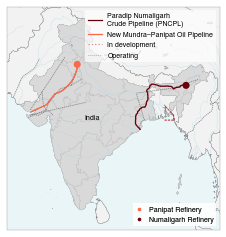

In [18]:
projectid_list = ['P3889', 'P3843']
linspace_list = list(numpy.linspace(0.5,1.0,projectid_list.__len__()))

map_crs = cartopy.crs.Mercator(central_longitude=105.0)
data_crs = cartopy.crs.PlateCarree()

fig = mp.figure(figsize=(3.25,5))

ax1 = fig.add_subplot(111, projection=map_crs)
ax1.set_extent([66,99,5,37], crs=cartopy.crs.PlateCarree())

ax1.add_geometries(ne_coastlines_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor=land_color, edgecolor=land_edge_color, linewidth=line_width)
ax1.add_geometries(ne_countries_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='None', edgecolor=land_edge_color, linewidth=line_width)
ax1.add_geometries(ne_countries_gdf.loc[ne_countries_gdf.SOVEREIGNT=='India'].geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor=country_color, edgecolor='None', linewidth=line_width)
ax1.add_geometries(ne_rivers_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='None', edgecolor='lightblue', linewidth=line_width)
ax1.add_geometries(ne_states_gdf.loc[ne_states_gdf.adm1_code.str.contains('IND')].geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='None', edgecolor=states_provinces_outline_color, linewidth=line_width)
ax1.add_geometries(ne_lakes_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='lightblue', edgecolor=land_edge_color, linewidth=line_width)
ax1.add_geometries(ne_oceans_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='lightblue', edgecolor='None', alpha=0.25)

shelved_routes = ax1.add_geometries(all_pipes_gdf.loc[
                                    (all_pipes_gdf.Status.isin(['Shelved']))&
                                    (all_pipes_gdf.Fuel=='Oil')].geometry,
                   crs=cartopy.crs.PlateCarree(),
                   facecolor='None', edgecolor=shelved_color, linewidth=shelved_pipeline_width,
                   capstyle='round', linestyle=shelved_linestyle)

oper_routes = ax1.add_geometries(all_pipes_gdf.loc[
                                    (all_pipes_gdf.Status.isin(['Operating']))&
                                    (all_pipes_gdf.Fuel=='Oil')].geometry,
                   crs=cartopy.crs.PlateCarree(),
                   facecolor='None', edgecolor=oper_color, linewidth=oper_pipeline_width,
                   capstyle='round', linestyle=oper_linestyle)

indev_routes = ax1.add_geometries(all_pipes_gdf.loc[
                                  (all_pipes_gdf.Status.isin(['Proposed','Construction']))&
                                    (all_pipes_gdf.Fuel=='Oil')].geometry,
                                  crs=cartopy.crs.PlateCarree(),
                                  facecolor='None', edgecolor=indev_color, linewidth=pipeline_width, alpha=indev_alpha,
                                  capstyle='round', linestyle=indev_linestyle)

for idx,project_id in enumerate(projectid_list):
    pipelines = ax1.add_geometries(all_pipes_gdf.loc[all_pipes_gdf.ProjectID==project_id].geometry,
                       crs=cartopy.crs.PlateCarree(),
                       facecolor='None', edgecolor=sel_cmap(linspace_list[idx]), linewidth=pipeline_width,
                       capstyle='round')

ax1.scatter(numaligarh_y, numaligarh_x,
            transform=cartopy.crs.PlateCarree(),
            marker='o', s=50, facecolor=sel_cmap(linspace_list[1]),
            edgecolor='None', zorder=10)

ax1.scatter(panipat_y, panipat_x,
            transform=cartopy.crs.PlateCarree(),
            marker='o', s=50, facecolor=sel_cmap(linspace_list[0]),
            edgecolor='None', zorder=10)

ax1.spines['geo'].set_edgecolor(land_edge_color)
ax1.spines['geo'].set_linewidth(line_width)

ax1.text(s='India', x=0.4, y=0.5, transform=ax1.transAxes, 
         verticalalignment='center',
         horizontalalignment='center',
         fontsize=7)

paradip_line = matplotlib.lines.Line2D([1], [1], color=sel_cmap(linspace_list[0]), linewidth=pipeline_width)
mundra_line = matplotlib.lines.Line2D([1], [1], color=sel_cmap(linspace_list[1]), linewidth=pipeline_width)
indev_line = matplotlib.lines.Line2D([1], [1], color=indev_color, linewidth=pipeline_width, alpha=indev_alpha, linestyle=indev_linestyle)
oper_line = matplotlib.lines.Line2D([1], [1], color=oper_color, linewidth=oper_pipeline_width, linestyle=oper_linestyle)
shelved_line = matplotlib.lines.Line2D([1], [1], color=shelved_color, linewidth=shelved_pipeline_width, linestyle=shelved_linestyle)

handles = [mundra_line,paradip_line,indev_line,oper_line]#,shelved_line]
labels = ['Paradip Numaligarh\nCrude Pipeline (PNCPL)','New Mundra–Panipat Oil Pipeline'] + ['In development', 'Operating']#, 'Shelved']

legend1 = mp.legend(handles=handles, labels=labels, fontsize=font_size,
                    frameon=True, framealpha=0.666,
                    fancybox=False, loc=0)
ax1.add_artist(legend1)

marker_panipat = matplotlib.lines.Line2D([], [], 
                                         color=sel_cmap(linspace_list[0]), 
                                         marker='o', linestyle='None',
                                         markersize=2.5)
marker_numaligarh = matplotlib.lines.Line2D([], [], 
                                         color=sel_cmap(linspace_list[1]), 
                                         marker='o', linestyle='None',
                                         markersize=2.5)
handles2 = [marker_panipat, marker_numaligarh]
labels2 = ['Panipat Refinery', 'Numaligarh Refinery']

legend2 = mp.legend(handles=handles2, 
                    labels=labels2, 
                    fontsize=font_size,
                    frameon=True,
                    fancybox=False, 
                    loc='lower right',
                    framealpha=0.666,
                    #handletextpad=None,
                    #borderpad=1,
                    #borderaxespad=None,
                    handlelength=1)
ax1.add_artist(legend2)

legend1.get_frame().set_linewidth(0)
legend2.get_frame().set_linewidth(0)

mp.tight_layout()
mp.savefig('saved-figures/India.png', dpi=600, bbox_inches='tight')
mp.savefig('saved-figures/India.pdf', bbox_inches='tight')

### china

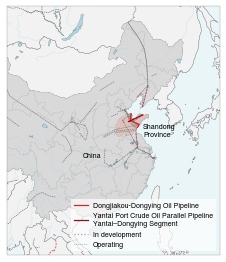

In [19]:
projectid_list = ['P2419', 'P3788']
linspace_list = [0.7,0.9]#list(numpy.linspace(0.5,1.0,projectid_list.__len__()))

map_crs = cartopy.crs.LambertConformal(standard_parallels=[33,45],
                                       central_longitude=104.1954,
                                       central_latitude=35.8617)
data_crs = cartopy.crs.PlateCarree()

fig = mp.figure(figsize=(3.25,5))

ax1 = fig.add_subplot(111, projection=map_crs)
#ax1.coastlines()
ax1.set_extent([95,130,15,55], crs=cartopy.crs.PlateCarree())

ax1.add_geometries(ne_coastlines_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor=land_color, edgecolor=land_edge_color, linewidth=line_width)
ax1.add_geometries(ne_countries_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='None', edgecolor=land_edge_color, linewidth=line_width)
ax1.add_geometries(ne_countries_gdf.loc[ne_countries_gdf.SOVEREIGNT=='China'].geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor=country_color, edgecolor='None', linewidth=line_width)
ax1.add_geometries(ne_rivers_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='None', edgecolor='lightblue', linewidth=line_width)
ax1.add_geometries(ne_states_gdf.loc[ne_states_gdf.adm1_code.str.contains('CHN')].geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='None', edgecolor=states_provinces_outline_color, linewidth=line_width)
ax1.add_geometries(ne_lakes_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='lightblue', edgecolor=land_edge_color, linewidth=line_width)
ax1.add_geometries(ne_oceans_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='lightblue', edgecolor='None', alpha=0.25)

# highlight shandong province
ax1.add_geometries(ne_states_gdf.loc[(ne_states_gdf.admin=='China')&
                  (ne_states_gdf.name=='Shandong')].geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor=sel_cmap(0.5), alpha=0.2, edgecolor=states_provinces_outline_color, linewidth=line_width)

# add pipelines
shelved_routes = ax1.add_geometries(all_pipes_gdf.loc[
                                    (all_pipes_gdf.Status.isin(['Shelved']))&
                                    (all_pipes_gdf.Fuel=='Oil')].geometry,
                   crs=cartopy.crs.PlateCarree(),
                   facecolor='None', edgecolor=shelved_color, linewidth=shelved_pipeline_width,
                   capstyle='round', linestyle=shelved_linestyle)

oper_routes = ax1.add_geometries(all_pipes_gdf.loc[
                                    (all_pipes_gdf.Status.isin(['Operating']))&
                                    (all_pipes_gdf.Fuel=='Oil')].geometry,
                   crs=cartopy.crs.PlateCarree(),
                   facecolor='None', edgecolor=oper_color, linewidth=oper_pipeline_width,
                   capstyle='round', linestyle=oper_linestyle)

indev_routes = ax1.add_geometries(all_pipes_gdf.loc[
                                  (all_pipes_gdf.Status.isin(['Proposed','Construction']))&
                                    (all_pipes_gdf.Fuel=='Oil')].geometry,
                                  crs=cartopy.crs.PlateCarree(),
                                  facecolor='None', edgecolor=indev_color, linewidth=pipeline_width, alpha=indev_alpha,
                                  capstyle='round', linestyle=indev_linestyle)

for idx,project_id in enumerate(projectid_list):
    pipelines = ax1.add_geometries(all_pipes_gdf.loc[all_pipes_gdf.ProjectID==project_id].geometry,
                       crs=cartopy.crs.PlateCarree(),
                       facecolor='None', edgecolor=sel_cmap(linspace_list[idx]), linewidth=pipeline_width,
                       capstyle='round')

ax1.spines['geo'].set_edgecolor(land_edge_color)
ax1.spines['geo'].set_linewidth(line_width)

ax1.text(s='China', x=0.4, y=0.4, transform=ax1.transAxes,
         verticalalignment='center',
         horizontalalignment='center', 
         fontsize=7)

ax1.text(s='Shandong\nProvince', x=0.64, y=0.5, transform=ax1.transAxes,
         verticalalignment='center',
         horizontalalignment='left', 
         fontsize=7)

dong_line = matplotlib.lines.Line2D([1], [1], color=sel_cmap(linspace_list[0]), linewidth=pipeline_width)
yantai_line = matplotlib.lines.Line2D([1], [1], color=sel_cmap(linspace_list[1]), linewidth=pipeline_width)
indev_line = matplotlib.lines.Line2D([1], [1], color=indev_color, linewidth=pipeline_width, alpha=indev_alpha, linestyle=indev_linestyle)
oper_line = matplotlib.lines.Line2D([1], [1], color=oper_color, linewidth=oper_pipeline_width, linestyle=oper_linestyle)
shelved_line = matplotlib.lines.Line2D([1], [1], color=shelved_color, linewidth=shelved_pipeline_width, linestyle=shelved_linestyle)

handles = [dong_line,yantai_line,indev_line,oper_line]#,shelved_line]
labels = ['Dongjiakou-Dongying Oil Pipeline', 
          'Yantai Port Crude Oil Parallel Pipeline\nYantai–Dongying Segment'] + ['In development', 'Operating']#, 'Shelved']

legend = mp.legend(handles=handles, labels=labels, fontsize=font_size,
         frameon=True, framealpha=0.666,
         fancybox=False, loc=4)

legend.get_frame().set_linewidth(0)

mp.tight_layout()
mp.savefig('saved-figures/China.png', dpi=600, bbox_inches='tight')
mp.savefig('saved-figures/China.pdf', bbox_inches='tight')

### russia

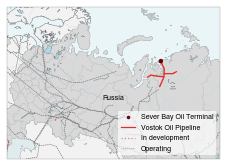

In [20]:
projectid_list = ['P3675', 'P3676', 'P3677']
#linspace_list = list(numpy.linspace(0.5,1.0,projectid_list.__len__()))
linspace_list = [0.666]*projectid_list.__len__()
terminals_color_list = [sel_cmap(0.999)]

#https://spatialreference.org/ref/sr-org/albers-equal-area-russia/prettywkt/
map_crs = cartopy.crs.AlbersEqualArea(central_latitude=56.0, 
                                      central_longitude=100.0, 
                                      false_easting=0.0, 
                                      false_northing=0.0, 
                                      standard_parallels=(50.0, 70.0), 
                                      globe=None)

# map_crs = cartopy.crs.AlbersEqualArea(central_latitude=65.0, 
#                                       central_longitude=70.0, 
#                                       false_easting=0.0, 
#                                       false_northing=0.0, 
#                                       standard_parallels=(50.0, 70.0), 
#                                       globe=None)

data_crs = cartopy.crs.PlateCarree()

fig = mp.figure(figsize=(3.25,4))

ax1 = fig.add_subplot(111, projection=map_crs)
ax1.set_extent([20,110,55,70], crs=cartopy.crs.PlateCarree())

ax1.add_geometries(ne_coastlines_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor=land_color, edgecolor=land_edge_color, linewidth=line_width)
ax1.add_geometries(ne_countries_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='None', edgecolor=land_edge_color, linewidth=line_width)
ax1.add_geometries(ne_countries_gdf.loc[ne_countries_gdf.SOVEREIGNT=='Russia'].geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor=country_color, edgecolor='None', linewidth=line_width)
ax1.add_geometries(ne_rivers_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='None', edgecolor='lightblue', linewidth=line_width)
ax1.add_geometries(ne_states_gdf.loc[ne_states_gdf.adm1_code.str.contains('RUS')].geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='None', edgecolor=states_provinces_outline_color, linewidth=line_width)
ax1.add_geometries(ne_lakes_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='lightblue', edgecolor=land_edge_color, linewidth=line_width)
ax1.add_geometries(ne_oceans_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='lightblue', edgecolor='None', alpha=0.25)

shelved_routes = ax1.add_geometries(all_pipes_gdf.loc[
                                    (all_pipes_gdf.Status.isin(['Shelved']))&
                                    (all_pipes_gdf.Fuel=='Oil')].geometry,
                   crs=cartopy.crs.PlateCarree(),
                   facecolor='None', edgecolor=shelved_color, linewidth=shelved_pipeline_width,
                   capstyle='round', linestyle=shelved_linestyle)

oper_routes = ax1.add_geometries(all_pipes_gdf.loc[
                                    (all_pipes_gdf.Status.isin(['Operating']))&
                                    (all_pipes_gdf.Fuel=='Oil')].geometry,
                   crs=cartopy.crs.PlateCarree(),
                   facecolor='None', edgecolor=oper_color, linewidth=oper_pipeline_width,
                   capstyle='round', linestyle=oper_linestyle)

indev_routes = ax1.add_geometries(all_pipes_gdf.loc[
                                  (all_pipes_gdf.Status.isin(['Proposed','Construction']))&
                                    (all_pipes_gdf.Fuel=='Oil')].geometry,
                                  crs=cartopy.crs.PlateCarree(),
                                  facecolor='None', edgecolor=indev_color, linewidth=pipeline_width, alpha=indev_alpha,
                                  capstyle='round', linestyle=indev_linestyle)

# add Sever Bay oil terminal
terminals_name_list = ['Sever Bay Oil Terminal']
lon_list = [80.38663813193077]
lat_list = [73.16625215603001]
scatter_plot = ax1.scatter(
    lon_list,
    lat_list,
    transform=cartopy.crs.PlateCarree(),
    facecolor=terminals_color_list, marker='o', s=20,
    edgecolor='None', zorder=10)

marker_list = []
for t_idx in range(terminals_name_list.__len__()):
    marker_list.append(matplotlib.lines.Line2D([], [], 
                                               color=terminals_color_list[t_idx], 
                                               marker='o', linestyle='None',
                                               markersize=2.5))#, label=terminals_name_list[t_idx]))

# add vostok oil pipelines
for idx,project_id in enumerate(projectid_list):
    pipelines = ax1.add_geometries(all_pipes_gdf.loc[all_pipes_gdf.ProjectID==project_id].geometry,
                       crs=cartopy.crs.PlateCarree(),
                       facecolor='None', edgecolor=sel_cmap(linspace_list[idx]), linewidth=pipeline_width,
                       capstyle='round')

ax1.spines['geo'].set_edgecolor(land_edge_color)
ax1.spines['geo'].set_linewidth(line_width)

ax1.text(s='Russia', x=0.5, y=0.4, transform=ax1.transAxes,
         verticalalignment='center',
         horizontalalignment='center', 
         fontsize=7)


vostok_line = matplotlib.lines.Line2D([1], [1], color=sel_cmap(linspace_list[0]), linewidth=pipeline_width)
indev_line = matplotlib.lines.Line2D([1], [1], color=indev_color, linewidth=pipeline_width, alpha=indev_alpha, linestyle=indev_linestyle)
oper_line = matplotlib.lines.Line2D([1], [1], color=oper_color, linewidth=oper_pipeline_width, linestyle=oper_linestyle)
shelved_line = matplotlib.lines.Line2D([1], [1], color=shelved_color, linewidth=shelved_pipeline_width, linestyle=shelved_linestyle)

handles = marker_list+[vostok_line,indev_line,oper_line]#,shelved_line]
labels = ['Sever Bay Oil Terminal'] + ['Vostok Oil Pipeline'] + ['In development', 'Operating']#, 'Shelved']

legend = mp.legend(handles=handles, labels=labels, fontsize=font_size,
         frameon=True, framealpha=0.666,
         fancybox=False, loc=4)

legend.get_frame().set_linewidth(0)

mp.tight_layout()
mp.savefig('saved-figures/Russia.png', dpi=600, bbox_inches='tight')
mp.savefig('saved-figures/Russia.pdf', bbox_inches='tight')

### north america

In [21]:
#P0033 = TMX expansion trans mountain oil pipeline
#p0032 = original trans mountain oil pipeline
# Enbridge Line 5 Oil Pipeline = pipelinename

### canada/northern US

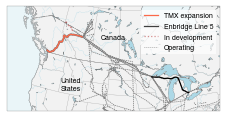

In [22]:
projectid_list = ['P0033', 'P2584', 'P0014','P3668']
#linspace_list = list(numpy.linspace(0.5,1.0,projectid_list.__len__()))

map_crs = cartopy.crs.AlbersEqualArea(central_longitude=-96.0, 
                                      central_latitude=39.0, 
                                      false_easting=0.0, 
                                      false_northing=0.0, 
                                      standard_parallels=(33.0, 45.0), 
                                      globe=None)
data_crs = cartopy.crs.PlateCarree()

fig = mp.figure(figsize=(3.25,4))

ax1 = fig.add_subplot(111, projection=map_crs)
ax1.set_extent([-130,-75,40,57], crs=cartopy.crs.PlateCarree())

ax1.add_geometries(ne_coastlines_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor=land_color, edgecolor=land_edge_color, linewidth=line_width)
ax1.add_geometries(ne_countries_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='None', edgecolor=land_edge_color, linewidth=line_width)
ax1.add_geometries(ne_rivers_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='None', edgecolor='lightblue', linewidth=line_width)
ax1.add_geometries(ne_states_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='None', edgecolor=states_provinces_outline_color, linewidth=line_width)
ax1.add_geometries(ne_lakes_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='lightblue', edgecolor=land_edge_color, linewidth=line_width)
ax1.add_geometries(ne_oceans_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='lightblue', edgecolor='None', alpha=0.25)

shelved_routes = ax1.add_geometries(all_pipes_gdf.loc[
                                    (all_pipes_gdf.Status.isin(['Shelved']))&
                                    (all_pipes_gdf.Fuel=='Oil')].geometry,
                   crs=cartopy.crs.PlateCarree(),
                   facecolor='None', edgecolor=shelved_color, linewidth=shelved_pipeline_width,
                   capstyle='round', linestyle=shelved_linestyle)

oper_routes = ax1.add_geometries(all_pipes_gdf.loc[
                                    (all_pipes_gdf.Status.isin(['Operating']))&
                                    (all_pipes_gdf.Fuel=='Oil')].geometry,
                   crs=cartopy.crs.PlateCarree(),
                   facecolor='None', edgecolor=oper_color, linewidth=oper_pipeline_width,
                   capstyle='round', linestyle=oper_linestyle)

indev_routes = ax1.add_geometries(all_pipes_gdf.loc[
                                  (all_pipes_gdf.Status.isin(['Proposed','Construction']))&
                                    (all_pipes_gdf.Fuel=='Oil')].geometry,
                                  crs=cartopy.crs.PlateCarree(),
                                  facecolor='None', edgecolor=indev_color, linewidth=pipeline_width, alpha=indev_alpha,
                                  capstyle='round', linestyle=indev_linestyle)

enbridge = ax1.add_geometries(all_pipes_gdf.loc[all_pipes_gdf.ProjectID.isin(['P2584', 'P0014'])].geometry,
                   crs=cartopy.crs.PlateCarree(),
                   facecolor='None', edgecolor='0', linewidth=pipeline_width,
                   capstyle='round')

tmp = ax1.add_geometries(all_pipes_gdf.loc[all_pipes_gdf.ProjectID=='P0032'].geometry,
                   crs=cartopy.crs.PlateCarree(),
                   facecolor='None', edgecolor='0.5', linewidth=2,
                   capstyle='round')

tmx = ax1.add_geometries(all_pipes_gdf.loc[all_pipes_gdf.ProjectID=='P0033'].geometry,
                   crs=cartopy.crs.PlateCarree(),
                   facecolor='None', edgecolor=sel_cmap(0.5), linewidth=pipeline_width,
                   capstyle='round')

ax1.spines['geo'].set_edgecolor(land_edge_color)
ax1.spines['geo'].set_linewidth(line_width)

tmx_line = matplotlib.lines.Line2D([1], [1], color=sel_cmap(0.5), linewidth=pipeline_width)
enbridge_line = matplotlib.lines.Line2D([1], [1], color='0.25', linewidth=pipeline_width)
indev_line = matplotlib.lines.Line2D([1], [1], color=indev_color, linewidth=pipeline_width, alpha=indev_alpha, linestyle=indev_linestyle)
oper_line = matplotlib.lines.Line2D([1], [1], color=oper_color, linewidth=oper_pipeline_width, linestyle=oper_linestyle)
shelved_line = matplotlib.lines.Line2D([1], [1], color=shelved_color, linewidth=shelved_pipeline_width, linestyle=shelved_linestyle)

handles = [tmx_line,enbridge_line,indev_line,oper_line]#,shelved_line]
labels = ['TMX expansion', 'Enbridge Line 5'] + ['In development', 'Operating']#, 'Shelved']

legend = mp.legend(handles=handles, labels=labels, fontsize=font_size,
         frameon=True, framealpha=0.666,
         fancybox=False)

ax1.text(s='Canada', x=0.5, y=0.7, transform=ax1.transAxes, 
         verticalalignment='center',
         horizontalalignment='center', 
         fontsize=7)

ax1.text(s='United\nStates', x=0.3, y=0.25, transform=ax1.transAxes, 
         verticalalignment='center',
         horizontalalignment='center', 
         fontsize=7)

legend.get_frame().set_linewidth(0)

mp.tight_layout()
mp.savefig('saved-figures/North-America.png', dpi=600, bbox_inches='tight')
mp.savefig('saved-figures/North-America.pdf', bbox_inches='tight')

### alaska (orig projection)

#### add AWNR boundary

In [23]:
usfws_refuge_gdf.loc[usfws_refuge_gdf.NWRNAME=='arc'].geometry

992     POLYGON ((399627.960 2270302.079, 399629.684 2...
2546    POLYGON ((412105.791 2275060.795, 412108.792 2...
Name: geometry, dtype: geometry

In [24]:
refuge_crs = cartopy.crs.AlbersEqualArea(central_longitude=-154.0, 
                                         central_latitude=50.0, 
                                         false_easting=0.0, 
                                         false_northing=0.0, 
                                         standard_parallels=(55.0, 65.0), 
                                         globe=None)

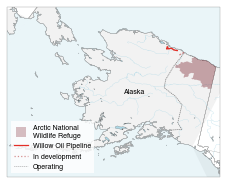

In [25]:
projectid_list = ['P0033', 'P2584', 'P0014','P3668']
#linspace_list = list(numpy.linspace(0.5,1.0,projectid_list.__len__()))

map_crs = cartopy.crs.AlbersEqualArea(central_longitude=-120.0, 
                                      central_latitude=39.0, 
                                      false_easting=0.0, 
                                      false_northing=0.0, 
                                      standard_parallels=(33.0, 45.0), 
                                      globe=None)

#map_crs = cartopy.crs.PlateCarree()
data_crs = cartopy.crs.PlateCarree()

fig = mp.figure(figsize=(3.25,3.25))

ax1 = fig.add_subplot(111, projection=map_crs)
ax1.set_extent([-175,-140,57,69], crs=cartopy.crs.PlateCarree())

ax1.add_geometries(ne_coastlines_10_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor=land_color, edgecolor=land_edge_color, linewidth=line_width)
ax1.add_geometries(ne_countries_10_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='None', edgecolor=land_edge_color, linewidth=line_width)
ax1.add_geometries(ne_rivers_10_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='None', edgecolor='lightblue', linewidth=line_width)
ax1.add_geometries(ne_states_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='None', edgecolor=states_provinces_outline_color, linewidth=line_width)
ax1.add_geometries(ne_lakes_10_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='lightblue', edgecolor=land_edge_color, linewidth=line_width)
ax1.add_geometries(ne_oceans_10_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='lightblue', edgecolor='None', alpha=0.25)

# add arctic national wildlife refuge
ax1.add_geometries(usfws_refuge_gdf.loc[usfws_refuge_gdf.NWRNAME=='arc'].geometry,
                   crs=refuge_crs, #cartopy.crs.PlateCarree(),
                   facecolor=sel_cmap(0.999), edgecolor='None', alpha=0.333)

shelved_routes = ax1.add_geometries(all_pipes_gdf.loc[
                                    (all_pipes_gdf.Status.isin(['Shelved']))&
                                    (all_pipes_gdf.Fuel=='Oil')].geometry,
                   crs=cartopy.crs.PlateCarree(),
                   facecolor='None', edgecolor=shelved_color, linewidth=shelved_pipeline_width,
                   capstyle='round', linestyle=shelved_linestyle)

oper_routes = ax1.add_geometries(all_pipes_gdf.loc[
                                    (all_pipes_gdf.Status.isin(['Operating']))&
                                    (all_pipes_gdf.Fuel=='Oil')].geometry,
                   crs=cartopy.crs.PlateCarree(),
                   facecolor='None', edgecolor=oper_color, linewidth=oper_pipeline_width,
                   capstyle='round', linestyle=oper_linestyle)

indev_routes = ax1.add_geometries(all_pipes_gdf.loc[
                                  (all_pipes_gdf.Status.isin(['Proposed','Construction']))&
                                    (all_pipes_gdf.Fuel=='Oil')].geometry,
                                  crs=cartopy.crs.PlateCarree(),
                                  facecolor='None', edgecolor=indev_color, linewidth=pipeline_width, alpha=indev_alpha,
                                  capstyle='round', linestyle=indev_linestyle)

willow = ax1.add_geometries(all_pipes_gdf.loc[all_pipes_gdf.ProjectID=='P3668'].geometry,
                   crs=cartopy.crs.PlateCarree(),
                   facecolor='None', edgecolor=sel_cmap(0.666), linewidth=pipeline_width,
                   capstyle='round')

ax1.spines['geo'].set_edgecolor(land_edge_color)
ax1.spines['geo'].set_linewidth(line_width)

willow_line = matplotlib.lines.Line2D([1], [1], color=sel_cmap(0.666), linewidth=pipeline_width)
indev_line = matplotlib.lines.Line2D([1], [1], color=indev_color, linewidth=pipeline_width, alpha=indev_alpha, linestyle=indev_linestyle)
oper_line = matplotlib.lines.Line2D([1], [1], color=oper_color, linewidth=oper_pipeline_width, linestyle=oper_linestyle)
shelved_line = matplotlib.lines.Line2D([1], [1], color=shelved_color, linewidth=shelved_pipeline_width, linestyle=shelved_linestyle)

anwr_box = matplotlib.lines.Line2D([], [], 
                                   color=sel_cmap(0.999),
                                   marker='s', linestyle='None',
                                   markersize=10, alpha=0.25, markeredgewidth=0)

handles = [anwr_box, willow_line,indev_line,oper_line]#,shelved_line]
labels = ['Arctic National\nWildlife Refuge', 'Willow Oil Pipeline'] + ['In development', 'Operating']#, 'Shelved']

legend = mp.legend(handles=handles, labels=labels, fontsize=font_size,
         frameon=True,
         fancybox=False, loc=3)

ax1.text(s='Alaska', x=0.6, y=0.5, transform=ax1.transAxes, 
         verticalalignment='center',
         horizontalalignment='center', 
         fontsize=7)

legend.get_frame().set_linewidth(0)

mp.tight_layout()
mp.savefig('saved-figures/North-America-Alaska.png', dpi=600, bbox_inches='tight')
mp.savefig('saved-figures/North-America-Alaska.pdf', bbox_inches='tight')

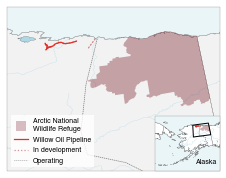

In [26]:
projectid_list = ['P0033', 'P2584', 'P0014','P3668']
#linspace_list = list(numpy.linspace(0.5,1.0,projectid_list.__len__()))

map_crs = cartopy.crs.AlbersEqualArea(central_longitude=-160.0, 
                                      central_latitude=39.0, 
                                      false_easting=0.0, 
                                      false_northing=0.0, 
                                      standard_parallels=(33.0, 45.0), 
                                      globe=None)

data_crs = cartopy.crs.PlateCarree()

fig = mp.figure(figsize=(3.25,3.25))

ax1 = fig.add_subplot(111, projection=map_crs)

willow_x0 = -155
willow_x1 = -141
willow_y0 = 65
willow_y1 = 71
ax1.set_extent([willow_x0, willow_x1, willow_y0, willow_y1], crs=cartopy.crs.PlateCarree())

ax1.add_geometries(ne_coastlines_10_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor=land_color, edgecolor=land_edge_color, linewidth=line_width)
ax1.add_geometries(ne_countries_10_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='None', edgecolor=land_edge_color, linewidth=line_width)
ax1.add_geometries(ne_rivers_10_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='None', edgecolor='lightblue', linewidth=line_width)
ax1.add_geometries(ne_states_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='None', edgecolor=states_provinces_outline_color, linewidth=line_width)
ax1.add_geometries(ne_lakes_10_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='lightblue', edgecolor=land_edge_color, linewidth=line_width)
ax1.add_geometries(ne_oceans_10_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='lightblue', edgecolor='None', alpha=0.25)

# add arctic national wildlife refuge
ax1.add_geometries(usfws_refuge_gdf.loc[usfws_refuge_gdf.NWRNAME=='arc'].geometry,
                   crs=refuge_crs, #cartopy.crs.PlateCarree(),
                   facecolor=sel_cmap(0.999), edgecolor='None', alpha=0.333)
shelved_routes = ax1.add_geometries(all_pipes_gdf.loc[
                                    (all_pipes_gdf.Status.isin(['Shelved']))&
                                    (all_pipes_gdf.Fuel=='Oil')].geometry,
                   crs=cartopy.crs.PlateCarree(),
                   facecolor='None', edgecolor=shelved_color, linewidth=shelved_pipeline_width,
                   capstyle='round', linestyle=shelved_linestyle)
oper_routes = ax1.add_geometries(all_pipes_gdf.loc[
                                    (all_pipes_gdf.Status.isin(['Operating']))&
                                    (all_pipes_gdf.Fuel=='Oil')].geometry,
                   crs=cartopy.crs.PlateCarree(),
                   facecolor='None', edgecolor=oper_color, linewidth=oper_pipeline_width,
                   capstyle='round', linestyle=oper_linestyle)
indev_routes = ax1.add_geometries(all_pipes_gdf.loc[
                                  (all_pipes_gdf.Status.isin(['Proposed','Construction']))&
                                    (all_pipes_gdf.Fuel=='Oil')].geometry,
                                  crs=cartopy.crs.PlateCarree(),
                                  facecolor='None', edgecolor=indev_color, linewidth=pipeline_width, alpha=indev_alpha,
                                  capstyle='round', linestyle=indev_linestyle)

enbridge = ax1.add_geometries(all_pipes_gdf.loc[all_pipes_gdf.ProjectID.isin(['P2584', 'P0014'])].geometry,
                   crs=cartopy.crs.PlateCarree(),
                   facecolor='None', edgecolor='0', linewidth=pipeline_width,
                   capstyle='round')
tmx = ax1.add_geometries(all_pipes_gdf.loc[all_pipes_gdf.ProjectID=='P0033'].geometry,
                   crs=cartopy.crs.PlateCarree(),
                   facecolor='None', edgecolor=sel_cmap(0.333), linewidth=pipeline_width,
                   capstyle='round')

willow = ax1.add_geometries(all_pipes_gdf.loc[all_pipes_gdf.ProjectID=='P3668'].geometry,
                   crs=cartopy.crs.PlateCarree(),
                   facecolor='None', edgecolor=sel_cmap(0.666), linewidth=pipeline_width,
                   capstyle='round')

ax1.spines['geo'].set_edgecolor(land_edge_color)
ax1.spines['geo'].set_linewidth(line_width)

willow_line = matplotlib.lines.Line2D([1], [1], color=sel_cmap(0.666), linewidth=pipeline_width)
indev_line = matplotlib.lines.Line2D([1], [1], color=indev_color, linewidth=pipeline_width, alpha=indev_alpha, linestyle=indev_linestyle)
oper_line = matplotlib.lines.Line2D([1], [1], color=oper_color, linewidth=oper_pipeline_width, linestyle=oper_linestyle)
shelved_line = matplotlib.lines.Line2D([1], [1], color=shelved_color, linewidth=shelved_pipeline_width, linestyle=shelved_linestyle)
anwr_box = matplotlib.lines.Line2D([], [], 
                                   color=sel_cmap(0.999),
                                   marker='s', linestyle='None',
                                   markersize=10, alpha=0.25, markeredgewidth=0)

handles = [anwr_box, willow_line,indev_line,oper_line]#,shelved_line]
labels = ['Arctic National\nWildlife Refuge', 'Willow Oil Pipeline'] + ['In development', 'Operating']#, 'Shelved']
legend = mp.legend(handles=handles, labels=labels, fontsize=font_size,
         frameon=True,
         fancybox=False, loc=3)

legend.get_frame().set_linewidth(0)

fig.tight_layout()

ax1pos = ax1.get_position()

# ********************************************************************************
# ********************************************************************************
# ********************************************************************************

ax2width = 1/3*(ax1pos.x1-ax1pos.x0)
ax2height = 1/3*(ax1pos.y1-ax1pos.y0)
# ax2 = fig.add_axes([ax1pos.x0-ax2width, ax1pos.y0, ax2width, ax2height],
#                   projection=map_crs)
ax2 = fig.add_axes([ax1pos.x0+2*ax2width+0.0125,
                    ax1pos.y0,
                    ax2width,
                    ax2height], projection=map_crs)

ax2.set_extent([-180,-140,50,75], crs=cartopy.crs.PlateCarree())

ax2.add_geometries(ne_coastlines_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='None', edgecolor=land_edge_color, linewidth=line_width)
ax2.add_geometries(ne_countries_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='None', edgecolor=land_edge_color, linewidth=line_width)
ax2.add_geometries(ne_rivers_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='None', edgecolor='lightblue', linewidth=line_width)
#ax1.add_geometries(ne_states_gdf.geometry,
#                  crs=cartopy.crs.PlateCarree(),
#                  facecolor='None', edgecolor=states_provinces_outline_color, linewidth=line_width)
ax2.add_geometries(ne_lakes_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='lightblue', edgecolor=land_edge_color, linewidth=line_width)
ax2.add_geometries(ne_oceans_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='lightblue', edgecolor='None', alpha=0.25)

# add arctic national wildlife refuge
ax2.add_geometries(usfws_refuge_gdf.loc[usfws_refuge_gdf.NWRNAME=='arc'].geometry,
                   crs=refuge_crs, #cartopy.crs.PlateCarree(),
                   facecolor=sel_cmap(0.999), edgecolor='None', alpha=0.333)
shelved_routes = ax2.add_geometries(all_pipes_gdf.loc[
                                    (all_pipes_gdf.Status.isin(['Shelved']))&
                                    (all_pipes_gdf.Fuel=='Oil')].geometry,
                   crs=cartopy.crs.PlateCarree(),
                   facecolor='None', edgecolor=shelved_color, linewidth=shelved_pipeline_width,
                   capstyle='round', linestyle=shelved_linestyle)
oper_routes = ax2.add_geometries(all_pipes_gdf.loc[
                                    (all_pipes_gdf.Status.isin(['Operating']))&
                                    (all_pipes_gdf.Fuel=='Oil')].geometry,
                   crs=cartopy.crs.PlateCarree(),
                   facecolor='None', edgecolor=oper_color, linewidth=oper_pipeline_width,
                   capstyle='round', linestyle=oper_linestyle)

indev_routes = ax2.add_geometries(all_pipes_gdf.loc[
                                  (all_pipes_gdf.Status.isin(['Proposed','Construction']))&
                                    (all_pipes_gdf.Fuel=='Oil')].geometry,
                                  crs=cartopy.crs.PlateCarree(),
                                  facecolor='None', edgecolor=indev_color, linewidth=pipeline_width, alpha=indev_alpha,
                                  capstyle='round', linestyle=indev_linestyle)

willow = ax2.add_geometries(all_pipes_gdf.loc[all_pipes_gdf.ProjectID=='P3668'].geometry,
                   crs=cartopy.crs.PlateCarree(),
                   facecolor='None', edgecolor=sel_cmap(0.666), linewidth=pipeline_width,
                   capstyle='round')

# add polygon
lons = [willow_x0, willow_x0, willow_x1, willow_x1]
lats = [willow_y0, willow_y1, willow_y1, willow_y0]
ring = shapely.geometry.polygon.LinearRing(list(zip(lons, lats)))
ax2.add_geometries([ring], crs=cartopy.crs.PlateCarree(), facecolor='none', edgecolor='black')

ax2.spines['geo'].set_edgecolor(land_edge_color)
ax2.spines['geo'].set_linewidth(line_width)

ax2.text(s='Alaska', x=0.8, y=0.15, transform=ax2.transAxes, 
         verticalalignment='center',
         horizontalalignment='center', 
         fontsize=7)

#fig.tight_layout()
mp.savefig('saved-figures/North-America-Alaska-zoomed.png', dpi=600, bbox_inches='tight')
mp.savefig('saved-figures/North-America-Alaska-zoomed.pdf', bbox_inches='tight')

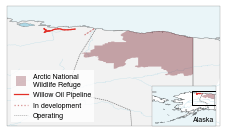

In [27]:
projectid_list = ['P0033', 'P2584', 'P0014','P3668']
#linspace_list = list(numpy.linspace(0.5,1.0,projectid_list.__len__()))

# map_crs = cartopy.crs.AlbersEqualArea(central_longitude=-160.0, 
#                                       central_latitude=39.0, 
#                                       false_easting=0.0, 
#                                       false_northing=0.0, 
#                                       standard_parallels=(33.0, 45.0), 
#                                       globe=None)
map_crs = cartopy.crs.PlateCarree()
data_crs = cartopy.crs.PlateCarree()

fig = mp.figure(figsize=(3.25,3.25))

ax1 = fig.add_subplot(111, projection=map_crs)

willow_x0 = -155
willow_x1 = -139
willow_y0 = 63
willow_y1 = 72
ax1.set_extent([willow_x0, willow_x1, willow_y0, willow_y1], crs=cartopy.crs.PlateCarree())

ax1.add_geometries(ne_coastlines_10_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor=land_color, edgecolor=land_edge_color, linewidth=line_width)
ax1.add_geometries(ne_countries_10_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='None', edgecolor=land_edge_color, linewidth=line_width)
ax1.add_geometries(ne_rivers_10_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='None', edgecolor='lightblue', linewidth=line_width)
ax1.add_geometries(ne_states_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='None', edgecolor=states_provinces_outline_color, linewidth=line_width)
ax1.add_geometries(ne_lakes_10_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='lightblue', edgecolor=land_edge_color, linewidth=line_width)
ax1.add_geometries(ne_oceans_10_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='lightblue', edgecolor='None', alpha=0.25)

# add arctic national wildlife refuge
ax1.add_geometries(usfws_refuge_gdf.loc[usfws_refuge_gdf.NWRNAME=='arc'].geometry,
                   crs=refuge_crs, #cartopy.crs.PlateCarree(),
                   facecolor=sel_cmap(0.999), edgecolor='None', alpha=0.333)
shelved_routes = ax1.add_geometries(all_pipes_gdf.loc[
                                    (all_pipes_gdf.Status.isin(['Shelved']))&
                                    (all_pipes_gdf.Fuel=='Oil')].geometry,
                   crs=cartopy.crs.PlateCarree(),
                   facecolor='None', edgecolor=shelved_color, linewidth=shelved_pipeline_width,
                   capstyle='round', linestyle=shelved_linestyle)
oper_routes = ax1.add_geometries(all_pipes_gdf.loc[
                                    (all_pipes_gdf.Status.isin(['Operating']))&
                                    (all_pipes_gdf.Fuel=='Oil')].geometry,
                   crs=cartopy.crs.PlateCarree(),
                   facecolor='None', edgecolor=oper_color, linewidth=oper_pipeline_width,
                   capstyle='round', linestyle=oper_linestyle)
indev_routes = ax1.add_geometries(all_pipes_gdf.loc[
                                  (all_pipes_gdf.Status.isin(['Proposed','Construction']))&
                                    (all_pipes_gdf.Fuel=='Oil')].geometry,
                                  crs=cartopy.crs.PlateCarree(),
                                  facecolor='None', edgecolor=indev_color, linewidth=pipeline_width, alpha=indev_alpha,
                                  capstyle='round', linestyle=indev_linestyle)

enbridge = ax1.add_geometries(all_pipes_gdf.loc[all_pipes_gdf.ProjectID.isin(['P2584', 'P0014'])].geometry,
                   crs=cartopy.crs.PlateCarree(),
                   facecolor='None', edgecolor='0', linewidth=pipeline_width,
                   capstyle='round')
tmx = ax1.add_geometries(all_pipes_gdf.loc[all_pipes_gdf.ProjectID=='P0033'].geometry,
                   crs=cartopy.crs.PlateCarree(),
                   facecolor='None', edgecolor=sel_cmap(0.333), linewidth=pipeline_width,
                   capstyle='round')

willow = ax1.add_geometries(all_pipes_gdf.loc[all_pipes_gdf.ProjectID=='P3668'].geometry,
                   crs=cartopy.crs.PlateCarree(),
                   facecolor='None', edgecolor=sel_cmap(0.666), linewidth=pipeline_width,
                   capstyle='round')

ax1.spines['geo'].set_edgecolor(land_edge_color)
ax1.spines['geo'].set_linewidth(line_width)

willow_line = matplotlib.lines.Line2D([1], [1], color=sel_cmap(0.666), linewidth=pipeline_width)
indev_line = matplotlib.lines.Line2D([1], [1], color=indev_color, linewidth=pipeline_width, alpha=indev_alpha, linestyle=indev_linestyle)
oper_line = matplotlib.lines.Line2D([1], [1], color=oper_color, linewidth=oper_pipeline_width, linestyle=oper_linestyle)
shelved_line = matplotlib.lines.Line2D([1], [1], color=shelved_color, linewidth=shelved_pipeline_width, linestyle=shelved_linestyle)
anwr_box = matplotlib.lines.Line2D([], [], 
                                   color=sel_cmap(0.999),
                                   marker='s', linestyle='None',
                                   markersize=10, alpha=0.25, markeredgewidth=0)

handles = [anwr_box, willow_line,indev_line,oper_line]#,shelved_line]
labels = ['Arctic National\nWildlife Refuge', 'Willow Oil Pipeline'] + ['In development', 'Operating']#, 'Shelved']
legend = mp.legend(handles=handles, labels=labels, fontsize=font_size,
         frameon=True,
         fancybox=False, loc=3)

legend.get_frame().set_linewidth(0)

fig.tight_layout()

ax1pos = ax1.get_position()

# ********************************************************************************
# ********************************************************************************
# ********************************************************************************

ax2width = 1/3*(ax1pos.x1-ax1pos.x0)
ax2height = 1/3*(ax1pos.y1-ax1pos.y0)
# ax2 = fig.add_axes([ax1pos.x0-ax2width, ax1pos.y0, ax2width, ax2height],
#                   projection=map_crs)
ax2 = fig.add_axes([ax1pos.x0+2*ax2width,#+0.0125,
                    ax1pos.y0,
                    ax2width,
                    ax2height], projection=map_crs)

ax2.set_extent([-180,-140,50,75], crs=cartopy.crs.PlateCarree())

ax2.add_geometries(ne_coastlines_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='None', edgecolor=land_edge_color, linewidth=line_width)
ax2.add_geometries(ne_countries_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='None', edgecolor=land_edge_color, linewidth=line_width)
ax2.add_geometries(ne_rivers_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='None', edgecolor='lightblue', linewidth=line_width)
#ax1.add_geometries(ne_states_gdf.geometry,
#                  crs=cartopy.crs.PlateCarree(),
#                  facecolor='None', edgecolor=states_provinces_outline_color, linewidth=line_width)
ax2.add_geometries(ne_lakes_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='lightblue', edgecolor=land_edge_color, linewidth=line_width)
ax2.add_geometries(ne_oceans_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='lightblue', edgecolor='None', alpha=0.25)

# add arctic national wildlife refuge
ax2.add_geometries(usfws_refuge_gdf.loc[usfws_refuge_gdf.NWRNAME=='arc'].geometry,
                   crs=refuge_crs, #cartopy.crs.PlateCarree(),
                   facecolor=sel_cmap(0.999), edgecolor='None', alpha=0.333)
shelved_routes = ax2.add_geometries(all_pipes_gdf.loc[
                                    (all_pipes_gdf.Status.isin(['Shelved']))&
                                    (all_pipes_gdf.Fuel=='Oil')].geometry,
                   crs=cartopy.crs.PlateCarree(),
                   facecolor='None', edgecolor=shelved_color, linewidth=shelved_pipeline_width,
                   capstyle='round', linestyle=shelved_linestyle)
oper_routes = ax2.add_geometries(all_pipes_gdf.loc[
                                    (all_pipes_gdf.Status.isin(['Operating']))&
                                    (all_pipes_gdf.Fuel=='Oil')].geometry,
                   crs=cartopy.crs.PlateCarree(),
                   facecolor='None', edgecolor=oper_color, linewidth=oper_pipeline_width,
                   capstyle='round', linestyle=oper_linestyle)

indev_routes = ax2.add_geometries(all_pipes_gdf.loc[
                                  (all_pipes_gdf.Status.isin(['Proposed','Construction']))&
                                    (all_pipes_gdf.Fuel=='Oil')].geometry,
                                  crs=cartopy.crs.PlateCarree(),
                                  facecolor='None', edgecolor=indev_color, linewidth=pipeline_width, alpha=indev_alpha,
                                  capstyle='round', linestyle=indev_linestyle)

willow = ax2.add_geometries(all_pipes_gdf.loc[all_pipes_gdf.ProjectID=='P3668'].geometry,
                   crs=cartopy.crs.PlateCarree(),
                   facecolor='None', edgecolor=sel_cmap(0.666), linewidth=pipeline_width,
                   capstyle='round')

# add polygon
lons = [willow_x0, willow_x0, willow_x1, willow_x1]
lats = [willow_y0, willow_y1, willow_y1, willow_y0]
ring = shapely.geometry.polygon.LinearRing(list(zip(lons, lats)))
ax2.add_geometries([ring], crs=cartopy.crs.PlateCarree(), facecolor='none', edgecolor='black')

ax2.spines['geo'].set_edgecolor(land_edge_color)
ax2.spines['geo'].set_linewidth(line_width)

ax2.text(s='Alaska', x=0.8, y=0.15, transform=ax2.transAxes, 
         verticalalignment='center',
         horizontalalignment='center', 
         fontsize=7)

#fig.tight_layout()
mp.savefig('saved-figures/North-America-Alaska-zoomed-flat-earth.png', dpi=600, bbox_inches='tight')
mp.savefig('saved-figures/North-America-Alaska-zoomed-flat-earth.pdf', bbox_inches='tight')

### gulf coast

get the proposed SPOT, etc. terminals for oil export

In [28]:
# import terminals
spreadsheet_terminals = gc.open_by_key('1tcS6Wd-Wp-LTDpLzFgJY_RSNDnbyubW3J_9HKIAys4A')
terms_df_orig = spreadsheet_terminals.worksheet('title', 'Terminals').get_as_df(start='A2')
terms_df_orig = terms_df_orig.loc[terms_df_orig.Wiki!='']
terms_df_orig.replace('--', numpy.nan, inplace=True)

In [29]:
terms_indev_oil_df = terms_df_orig.loc[(terms_df_orig.Fuel=='Oil')&
                                       (terms_df_orig.Status.isin(['Construction','Proposed']))]
terms_indev_oil_df['geometry'] = numpy.nan
for idx,row in terms_indev_oil_df.iterrows():
    terms_indev_oil_df.loc[idx,'geometry'] = shapely.geometry.Point(row.Longitude, row.Latitude)

terms_indev_oil_df = terms_indev_oil_df.sort_values('Longitude')
terms_indev_oil_df_unique = terms_indev_oil_df.loc[terms_indev_oil_df.ComboID!='T073902']

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_72114/2087380259.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  terms_indev_oil_df['geometry'] = numpy.nan
/Users/baird/miniconda3/envs/gem/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [30]:
terms_indev_oil_df_unique

,TerminalID,ProjectID,ComboID,Wiki,TerminalName,UnitName,Status,Fuel,Import/Export,Country,...,ExportFigureClarkWilliamsDerry,IGUWorldLNGReportAppendix2,Construction_Sanctioned_July_2022,CostUSDPerBcm/y,CostUSDPerMtpa,ProposalYearMonth,FIDYearMonth,ConstructionYearMonth,StartYear1YearMonth,geometry
909,T0743,0,T074300,https://www.gem.wiki/Brownsville_Oil_Terminal,Brownsville Terminal,,Proposed,Oil,Export,United States,...,,,,NaN,NaN,,,,,POINT (-97.089947 26.061639)
905,T0739,1,T073901,https://www.gem.wiki/Bluewater_Texas_(BWTX)_Te...,Bluewater Texas (BWTX) Terminal,Terminal 1,Proposed,Oil,Export,United States,...,,,,NaN,NaN,,,,,POINT (-96.62764626 27.90491077)
900,T0734,0,T073400,https://www.gem.wiki/Sea_Port_Oil_Terminal_(SPOT),Sea Port Oil Terminal (SPOT),,Proposed,Oil,Export,United States,...,,,,NaN,NaN,,,,,POINT (-95.08685234 28.45570851)
1113,T0994,1,T099401,https://www.gem.wiki/Texas_Gulflink_Deepwater_...,Texas GulfLink Deepwater Port,,Proposed,Oil,Export,United States,...,,,,NaN,NaN,,,,,POINT (-94.5821725 28.49438658)
1112,T0993,1,T099301,https://www.gem.wiki/Blue_Marlin_Offshore_Port,Blue Marlin Offshore Port,,Proposed,Oil,Export,United States,...,,,,NaN,NaN,,,,,POINT (-93.01 28.425)
908,T0742,0,T074200,https://www.gem.wiki/NOLA_Oil_Terminal,NOLA Oil Terminal,,Construction,Oil,Export,United States,...,,,,NaN,NaN,,,,,POINT (-89.942134 29.644625)


#### save geojson for David Hoffman

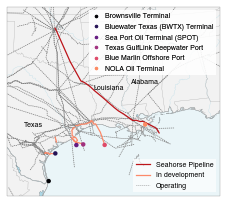

In [32]:
projectid_list = ['P0033', 'P2584', 'P0014','P3668']
#linspace_list = list(numpy.linspace(0.5,1.0,projectid_list.__len__()))
terminals_color_list = [matplotlib.cm.get_cmap('magma')(i) for i in numpy.linspace(0.,0.75,terms_indev_oil_df_unique.geometry.size)]
terminals_name_list = terms_indev_oil_df_unique.TerminalName.to_list()

map_crs = cartopy.crs.AlbersEqualArea(central_longitude=-96.0, 
                                      central_latitude=39.0, 
                                      false_easting=0.0, 
                                      false_northing=0.0, 
                                      standard_parallels=(33.0, 45.0), 
                                      globe=None)
data_crs = cartopy.crs.PlateCarree()

fig = mp.figure(figsize=(3.25,3.25))

ax1 = fig.add_subplot(111, projection=map_crs)
ax1.set_extent([-100,-85,25,37], crs=cartopy.crs.PlateCarree())

ax1.add_geometries(ne_coastlines_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor=land_color, edgecolor=land_edge_color, linewidth=line_width)
ax1.add_geometries(ne_countries_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='None', edgecolor=land_edge_color, linewidth=line_width)
ax1.add_geometries(ne_rivers_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='None', edgecolor='lightblue', linewidth=line_width)
ax1.add_geometries(ne_states_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='None', edgecolor=states_provinces_outline_color, linewidth=line_width)
ax1.add_geometries(ne_lakes_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='lightblue', edgecolor=land_edge_color, linewidth=line_width)
ax1.add_geometries(ne_oceans_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='lightblue', edgecolor='None', alpha=0.25)

# shelved_routes = ax1.add_geometries(all_pipes_gdf.loc[
#                                     (all_pipes_gdf.Status.isin(['Shelved']))&
#                                     (all_pipes_gdf.Fuel=='Oil')].geometry,
#                    crs=cartopy.crs.PlateCarree(),
#                    facecolor='None', edgecolor=shelved_color, linewidth=shelved_pipeline_width,
#                    capstyle='round', linestyle=shelved_linestyle)

oper_routes = ax1.add_geometries(all_pipes_gdf.loc[
                                    (all_pipes_gdf.Status.isin(['Operating']))&
                                    (all_pipes_gdf.Fuel=='Oil')].geometry,
                   crs=cartopy.crs.PlateCarree(),
                   facecolor='None', edgecolor=oper_color, linewidth=oper_pipeline_width,
                   capstyle='round', linestyle=oper_linestyle)

indev_routes = ax1.add_geometries(all_pipes_gdf.loc[
                                  (all_pipes_gdf.Status.isin(['Proposed','Construction']))&
                                    (all_pipes_gdf.Fuel=='Oil')&
                                    (all_pipes_gdf.PipelineName!='Seahorse Pipeline')].geometry,
                                  crs=cartopy.crs.PlateCarree(),
                                  facecolor='None', edgecolor=sel_cmap(0.4), linewidth=pipeline_width, alpha=1,#indev_alpha,
                                  capstyle='round')

seahorse = ax1.add_geometries(all_pipes_gdf.loc[
                                  (all_pipes_gdf.Status.isin(['Proposed','Construction']))&
                                    (all_pipes_gdf.Fuel=='Oil')&
                                    (all_pipes_gdf.PipelineName=='Seahorse Pipeline')].geometry,
                                  crs=cartopy.crs.PlateCarree(),
                                  facecolor='None', edgecolor=sel_cmap(0.8), linewidth=pipeline_width, alpha=1,
                                  capstyle='round')


lon_list = [point.x for point in terms_indev_oil_df_unique.geometry]
lat_list = [point.y for point in terms_indev_oil_df_unique.geometry]
scatter_plot = ax1.scatter(
    lon_list,
    lat_list,
    transform=cartopy.crs.PlateCarree(),
    facecolor=terminals_color_list, marker='o', s=20,
    edgecolor='None', zorder=10, label=terminals_name_list)

marker_list = []
for t_idx in range(terminals_name_list.__len__()):
    marker_list.append(matplotlib.lines.Line2D([], [], 
                                               color=terminals_color_list[t_idx], 
                                               marker='o', linestyle='None',
                                               markersize=2.5))#, label=terminals_name_list[t_idx]))

ax1.spines['geo'].set_edgecolor(land_edge_color)
ax1.spines['geo'].set_linewidth(line_width)

seahorse_line = matplotlib.lines.Line2D([1], [1], color=sel_cmap(0.8), linewidth=pipeline_width)
indev_line = matplotlib.lines.Line2D([1], [1], color=sel_cmap(0.4), linewidth=pipeline_width)#, alpha=indev_alpha)
oper_line = matplotlib.lines.Line2D([1], [1], color=oper_color, linewidth=oper_pipeline_width, linestyle=oper_linestyle)
shelved_line = matplotlib.lines.Line2D([1], [1], color=shelved_color, linewidth=shelved_pipeline_width, linestyle=shelved_linestyle)

handles1 = [seahorse_line, indev_line,oper_line]#,shelved_line]
labels1 = ['Seahorse Pipeline', 'In development', 'Operating']#, 'Shelved']
legend1 = ax1.legend(handles=handles1, 
                     labels=labels1, 
                     fontsize=font_size,
                     frameon=True,
                     fancybox=False,
                     framealpha=0.666,
                     loc='lower right')
ax1.add_artist(legend1)

legend2 = mp.legend(handles=marker_list, 
                    labels=terminals_name_list, 
                    fontsize=font_size,
                    frameon=True,
                    fancybox=False, 
                    loc='upper right',
                    framealpha=0.666,
                    #handletextpad=None,
                    #borderpad=1,
                    #borderaxespad=None,
                    handlelength=1)
ax1.add_artist(legend2)

ax1.text(s='Louisiana', x=0.48, y=0.57, transform=ax1.transAxes, 
         verticalalignment='center',
         horizontalalignment='center', 
         fontsize=7)

ax1.text(s='Texas', x=0.125, y=0.375, transform=ax1.transAxes, 
         verticalalignment='center',
         horizontalalignment='center', 
         fontsize=7)

ax1.text(s='Alabama', x=0.65, y=0.6, transform=ax1.transAxes, 
         verticalalignment='center',
         horizontalalignment='center', 
         fontsize=7)

legend1.get_frame().set_linewidth(0)
legend2.get_frame().set_linewidth(0)

mp.tight_layout()
mp.savefig('saved-figures/North-America-Gulf-Coast.png', dpi=600, bbox_inches='tight')
mp.savefig('saved-figures/North-America-Gulf-Coast.pdf', bbox_inches='tight')

#### geojson for David Hoffman of pipelines

In [33]:
filename = 'oil-report-2022-proposed-contruction-pipelines.geojson'
all_pipes_gdf.loc[(all_pipes_gdf.Status.isin(['Proposed','Construction']))&
                  (all_pipes_gdf.Fuel=='Oil')].to_file(filename, driver='GeoJSON')
print('saved as', filename)

saved as oil-report-2022-proposed-contruction-pipelines.geojson


### mena

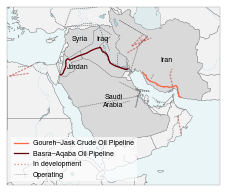

In [82]:
projectid_list = ['P2224', 'P0544']
countries = ['Syria','Iraq','Iran','Jordan','Saudi Arabia'] # to darklight
linspace_list = list(numpy.linspace(0.5,1.0,projectid_list.__len__()))

map_crs = cartopy.crs.Mercator(central_longitude=42.5510)
data_crs = cartopy.crs.PlateCarree()

fig = mp.figure(figsize=(3.25,3.25))

ax1 = fig.add_subplot(111, projection=map_crs)
#ax1.coastlines()
ax1.set_extent([25,65,10,40], crs=cartopy.crs.PlateCarree())

ax1.add_geometries(ne_coastlines_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor=land_color, edgecolor=land_edge_color, linewidth=line_width)
ax1.add_geometries(ne_countries_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='None', edgecolor=land_edge_color, linewidth=line_width)

ax1.add_geometries(ne_countries_gdf.loc[ne_countries_gdf.SOVEREIGNT.isin(countries)].geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor=country_color, edgecolor=land_edge_color, linewidth=line_width)

ax1.add_geometries(ne_rivers_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='None', edgecolor='lightblue', linewidth=line_width)
ax1.add_geometries(ne_lakes_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='lightblue', edgecolor=land_edge_color, linewidth=line_width)
ax1.add_geometries(ne_oceans_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='lightblue', edgecolor='None', alpha=0.25)

oper_routes = ax1.add_geometries(all_pipes_gdf.loc[
                                    (all_pipes_gdf.Status.isin(['Operating']))&
                                    (all_pipes_gdf.Fuel=='Oil')].geometry,
                   crs=cartopy.crs.PlateCarree(),
                   facecolor='None', edgecolor=oper_color, linewidth=oper_pipeline_width,
                   capstyle='round', linestyle=oper_linestyle)

indev_routes = ax1.add_geometries(all_pipes_gdf.loc[
                                  (all_pipes_gdf.Status.isin(['Proposed','Construction']))&
                                    (all_pipes_gdf.Fuel=='Oil')].geometry,
                                  crs=cartopy.crs.PlateCarree(),
                                  facecolor='None', edgecolor=indev_color, linewidth=pipeline_width, alpha=indev_alpha,
                                  capstyle='round', linestyle=indev_linestyle)

for idx,project_id in enumerate(projectid_list):
    pipelines = ax1.add_geometries(all_pipes_gdf.loc[all_pipes_gdf.ProjectID==project_id].geometry,
                       crs=cartopy.crs.PlateCarree(),
                       facecolor='None', edgecolor=sel_cmap(linspace_list[idx]), linewidth=pipeline_width,
                       capstyle='round')

ax1.spines['geo'].set_edgecolor(land_edge_color)
ax1.spines['geo'].set_linewidth(line_width)

basra_aqaba_line = matplotlib.lines.Line2D([1], [1], color=sel_cmap(linspace_list[1]), linewidth=pipeline_width)
goureh_jask_line = matplotlib.lines.Line2D([1], [1], color=sel_cmap(linspace_list[0]), linewidth=pipeline_width)
indev_line = matplotlib.lines.Line2D([1], [1], color=indev_color, linewidth=pipeline_width, alpha=indev_alpha, linestyle=indev_linestyle)
oper_line = matplotlib.lines.Line2D([1], [1], color=oper_color, linewidth=oper_pipeline_width, linestyle=oper_linestyle)
shelved_line = matplotlib.lines.Line2D([1], [1], color=shelved_color, linewidth=shelved_pipeline_width, linestyle=shelved_linestyle)

handles = [goureh_jask_line,basra_aqaba_line,indev_line,oper_line]#,shelved_line]
labels = ['Goureh–Jask Crude Oil Pipeline', 'Basra–Aqaba Oil Pipeline'] + ['In development', 'Operating']#, 'Shelved']

legend = mp.legend(handles=handles, labels=labels, fontsize=font_size,
         frameon=True, framealpha=0.666,
         fancybox=False, loc=3)

ax1.text(s='Saudi\nArabia', x=0.5, y=0.47, transform=ax1.transAxes, 
         verticalalignment='center',
         horizontalalignment='center', 
         fontsize=font_size)

ax1.text(s='Jordan', x=0.33, y=0.66, transform=ax1.transAxes, 
         verticalalignment='center',
         horizontalalignment='center', 
         fontsize=font_size, rotation=0)

ax1.text(s='Iraq', x=0.45, y=0.82, transform=ax1.transAxes, 
         verticalalignment='center',
         horizontalalignment='center', 
         fontsize=font_size, rotation=0)

ax1.text(s='Syria', x=0.34, y=0.82, transform=ax1.transAxes, 
         verticalalignment='center',
         horizontalalignment='center', 
         fontsize=font_size, rotation=0)

ax1.text(s='Iran', x=0.75, y=0.7, transform=ax1.transAxes, 
         verticalalignment='center',
         horizontalalignment='center', 
         fontsize=font_size, rotation=0)

legend.get_frame().set_linewidth(0)

mp.tight_layout()
mp.savefig('saved-figures/MENA.png', dpi=600, bbox_inches='tight')
mp.savefig('saved-figures/MENA.pdf', bbox_inches='tight')

### sub-saharan africa

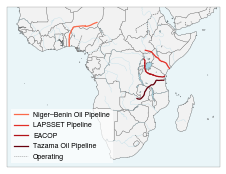

In [98]:
# lightest first, darkest last
# niger-benin, lapsset lapsset, eacop, tazama
projectid_list = ['P1328', 'P0531', 'P0538', 'P0541', 'P2481']
linspace_list = list(numpy.linspace(0.5,1.0,4))
linspace_list.insert(1, linspace_list[1])

map_crs = cartopy.crs.Mercator(central_longitude=34.5085)
data_crs = cartopy.crs.PlateCarree()

fig = mp.figure(figsize=(3.25,3.25))

ax1 = fig.add_subplot(111, projection=map_crs)
#ax1.coastlines()
ax1.set_extent([-21,60,-37,21], crs=cartopy.crs.PlateCarree())

ax1.add_geometries(ne_coastlines_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor=land_color, edgecolor=land_edge_color, linewidth=line_width)
ax1.add_geometries(ne_countries_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='None', edgecolor=land_edge_color, linewidth=line_width)
ax1.add_geometries(ne_countries_gdf.loc[ne_countries_gdf.SOVEREIGNT=='Africa'].geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor=country_color, edgecolor='None', linewidth=line_width)
ax1.add_geometries(ne_rivers_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='None', edgecolor='lightblue', linewidth=line_width)
ax1.add_geometries(ne_lakes_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='lightblue', edgecolor=land_edge_color, linewidth=line_width)
ax1.add_geometries(ne_oceans_gdf.geometry,
                  crs=cartopy.crs.PlateCarree(),
                  facecolor='lightblue', edgecolor='None', alpha=0.25)

oper_routes = ax1.add_geometries(all_pipes_gdf.loc[
                                    (all_pipes_gdf.Status.isin(['Operating']))&
                                    (all_pipes_gdf.Fuel=='Oil')].geometry,
                   crs=cartopy.crs.PlateCarree(),
                   facecolor='None', edgecolor=oper_color, linewidth=oper_pipeline_width,
                   capstyle='round', linestyle=oper_linestyle)

# indev_routes = ax1.add_geometries(all_pipes_gdf.loc[
#                                   (all_pipes_gdf.Status.isin(['Proposed','Construction']))&
#                                     (all_pipes_gdf.Fuel=='Oil')].geometry,
#                                   crs=cartopy.crs.PlateCarree(),
#                                   facecolor='None', edgecolor=indev_color, linewidth=pipeline_width, alpha=indev_alpha,
#                                   capstyle='round', linestyle=indev_linestyle)

names = []
for idx,project_id in enumerate(projectid_list):
    pipelines = ax1.add_geometries(all_pipes_gdf.loc[all_pipes_gdf.ProjectID==project_id].geometry,
                       crs=cartopy.crs.PlateCarree(),
                       facecolor='None', edgecolor=sel_cmap(linspace_list[idx]), linewidth=pipeline_width,
                       capstyle='round')
    names.append(all_pipes_gdf.loc[all_pipes_gdf.ProjectID==project_id].PipelineName)

ax1.spines['geo'].set_edgecolor(land_edge_color)
ax1.spines['geo'].set_linewidth(line_width)

#niger-benin, lapsset, lapsset, eacop, tazama
niger_benin_line = matplotlib.lines.Line2D([1], [1], color=sel_cmap(linspace_list[0]), linewidth=pipeline_width)
lapsset_line = matplotlib.lines.Line2D([1], [1], color=sel_cmap(linspace_list[1]), linewidth=pipeline_width)
eacop_line = matplotlib.lines.Line2D([1], [1], color=sel_cmap(linspace_list[3]), linewidth=pipeline_width)
tazama_line = matplotlib.lines.Line2D([1], [1], color=sel_cmap(linspace_list[4]), linewidth=pipeline_width)
indev_line = matplotlib.lines.Line2D([1], [1], color=indev_color, linewidth=pipeline_width, alpha=indev_alpha, linestyle=indev_linestyle)
oper_line = matplotlib.lines.Line2D([1], [1], color=oper_color, linewidth=oper_pipeline_width, linestyle=oper_linestyle)
shelved_line = matplotlib.lines.Line2D([1], [1], color=shelved_color, linewidth=shelved_pipeline_width, linestyle=shelved_linestyle)

handles = [niger_benin_line,lapsset_line,eacop_line,tazama_line] + [oper_line] #[indev_line,oper_line]#,shelved_line]
labels = ['Niger–Benin Oil Pipeline','LAPSSET Pipeline','EACOP','Tazama Oil Pipeline'] + ['Operating'] #['In development', 'Operating']#, 'Shelved']

legend = mp.legend(handles=handles, labels=labels, fontsize=font_size,
         frameon=True, framealpha=0.666,
         fancybox=False, loc=3)

legend.get_frame().set_linewidth(0)

mp.tight_layout()
mp.savefig('saved-figures/Sub-Saharan-Africa.png', dpi=600, bbox_inches='tight')
mp.savefig('saved-figures/Sub-Saharan-Africa.pdf', bbox_inches='tight')